In [1]:
import os
import pickle
from kid_readout.utils import readoutnc
from kid_readout.analysis import noise_measurement
plt.rcParams['font.size'] = 11
import utilities

updated file list


:0: FutureWarning: IPython widgets are experimental and may change in the future.


In [2]:
data_directory = '/data/readout'
save_directory = '../Max/2015-12-21_log-binned_before_pca_variable'
resonator_index = 13  # This should be the 164 MHz resonance, aka channel 8
pca_NFFT = 2**15

In [3]:
with open('cw_ncs.pkl') as f:
    cw_ncs = pickle.load(f)
with open('bb_ncs.pkl') as f:
    bb_ncs = pickle.load(f)
with open('cw_total_turns_to_atten.pkl') as f:
    cw_total_turns_to_atten = pickle.load(f)
with open('bb_total_turns_to_atten.pkl') as f:
    bb_total_turns_to_atten = pickle.load(f)

In [4]:
# These are the sweep/timestream indices for the source-on data:
atten_to_index = {41: 3,
                  38: 4,
                  35: 5,
                  32: 6,
                  29: 7,
                  26: 8,
                  23: 9}

The sweep/stream pairs consist of  
0 41 coarse off / short modulated on coarse  
1 41 fine off / long modulated off  
2 41 coarse on / short modulated on coarse  
3 41 fine on / long on  
4 38 fine on / long on  
5 35 fine on / long on  
6 32 fine on / long on  
7 29 fine on / long on  
8 26 fine on / long on  
9 23 fine on / long on

In [5]:
def load_snm(source, total_turns, **kwargs):
    if source == 'cw':
        nc = cw_ncs[total_turns]
        atten = cw_total_turns_to_atten[total_turns]
    elif source == 'bb':
        nc = bb_ncs[total_turns]
        atten = bb_total_turns_to_atten[total_turns]
    else:
        raise ValueError("Invalid source state!")   
    index = atten_to_index[atten]
    snm = noise_measurement.SweepNoiseMeasurement(nc,
                                                  sweep_group_index=index,
                                                  timestream_group_index=index,
                                                  resonator_index=resonator_index,
                                                  pca_NFFT=pca_NFFT,
                                                  **kwargs)
    if not sum(snm.mmw_atten_turns) == total_turns:
        raise ValueError("Incorrect turns!")
    if not snm.atten == atten:
        raise ValueError("Incorrect atten!")
    return snm

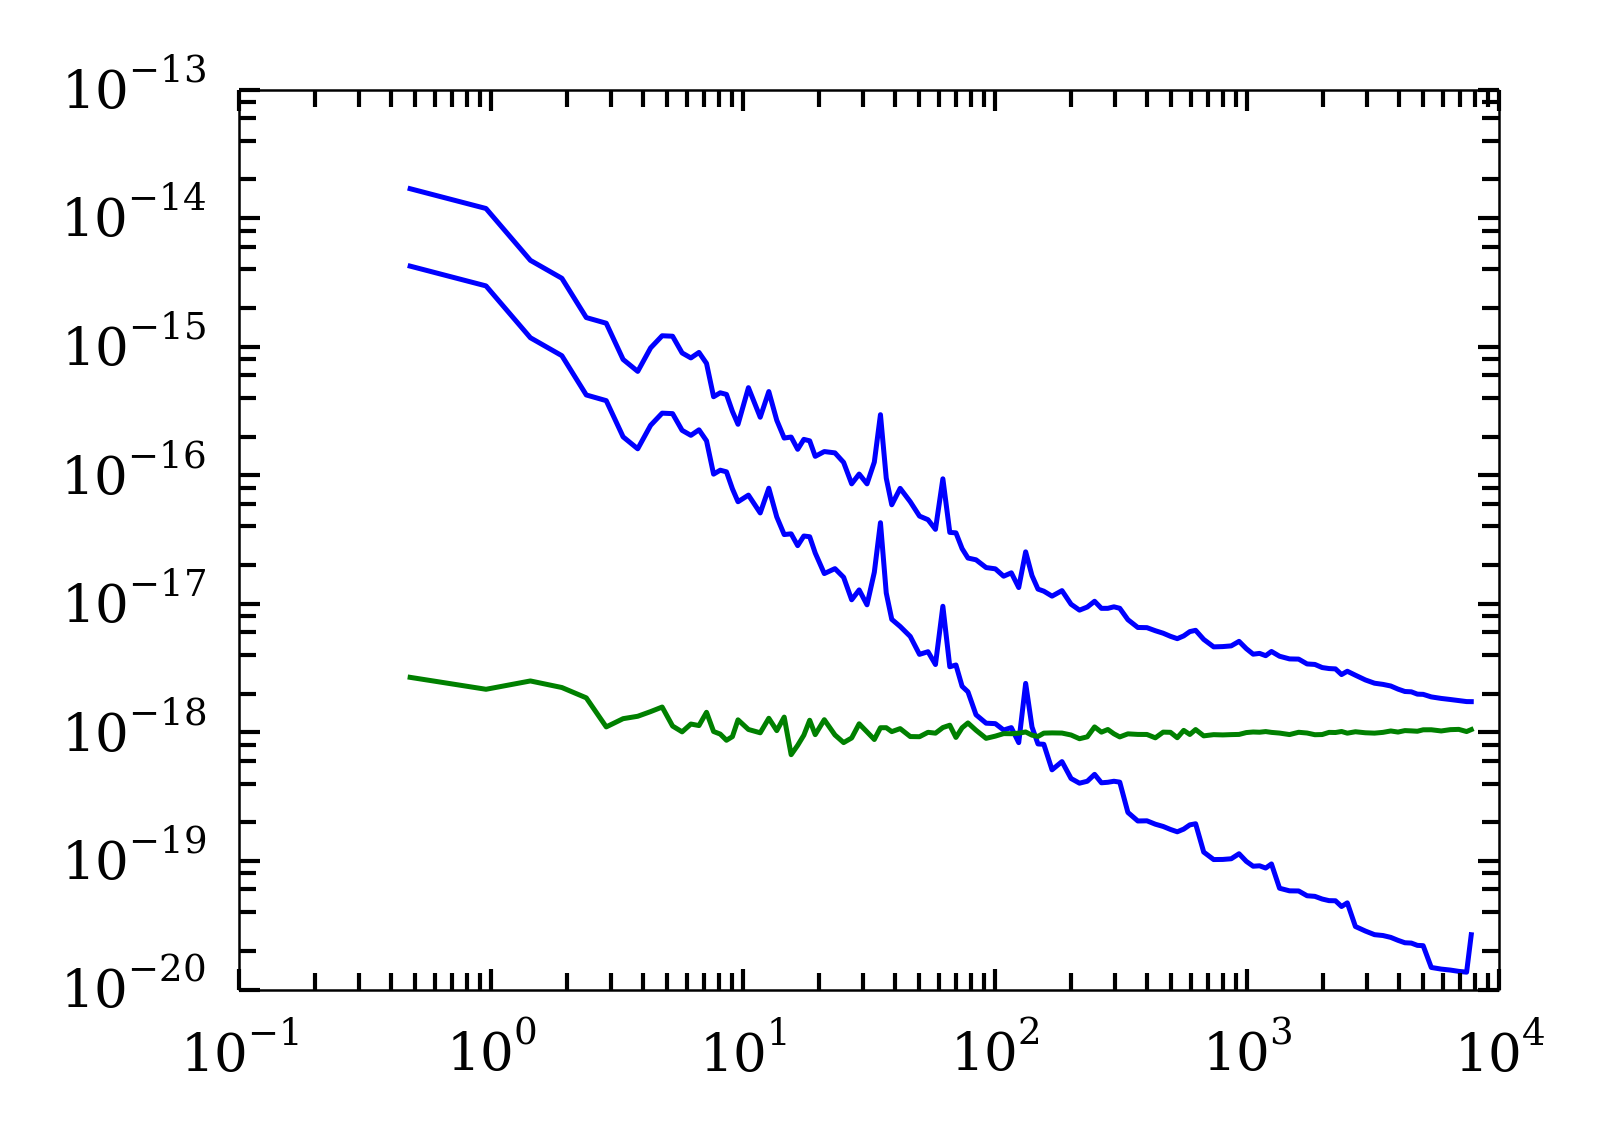

In [8]:
plt.loglog(cw07.epca_freq, cw07.epca_evals[1], '-b')
plt.loglog(cw07.epca_freq, cw07.epca_variance[1]**(1/2), '-b')
plt.loglog(cw07.epca_freq, cw07.epca_evals[0], '-g')

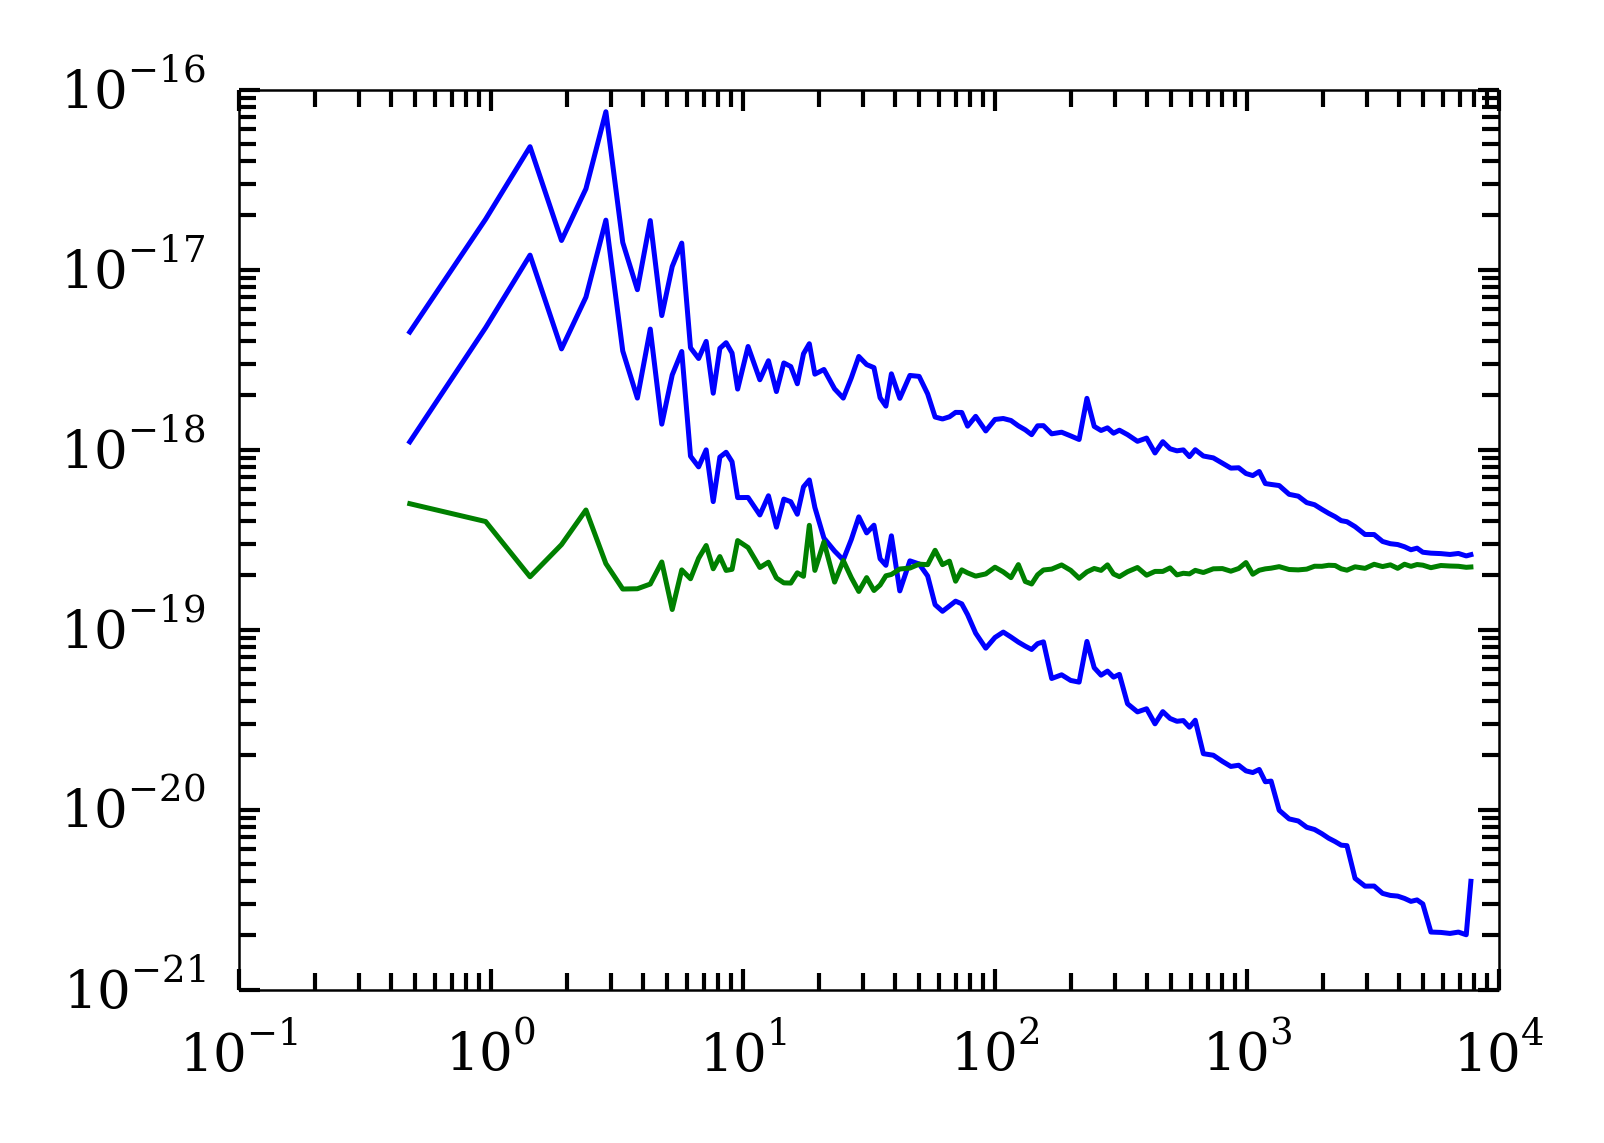

In [10]:
plt.loglog(cw17.epca_freq, cw17.epca_evals[1], '-b')
plt.loglog(cw17.epca_freq, cw17.epca_variance[1]**(1/2), '-b')
plt.loglog(cw17.epca_freq, cw17.epca_evals[0], '-g')

# Despiking broadband data

In [12]:
bb06 = load_snm('bb', 6)

In [13]:
n_masked = 4
f_mask = 10
bb_highest = ((bb06.epca_freq <= f_mask).sum() +
               bb06.epca_evals[1][bb06.epca_freq > f_mask].argsort())[-n_masked:]

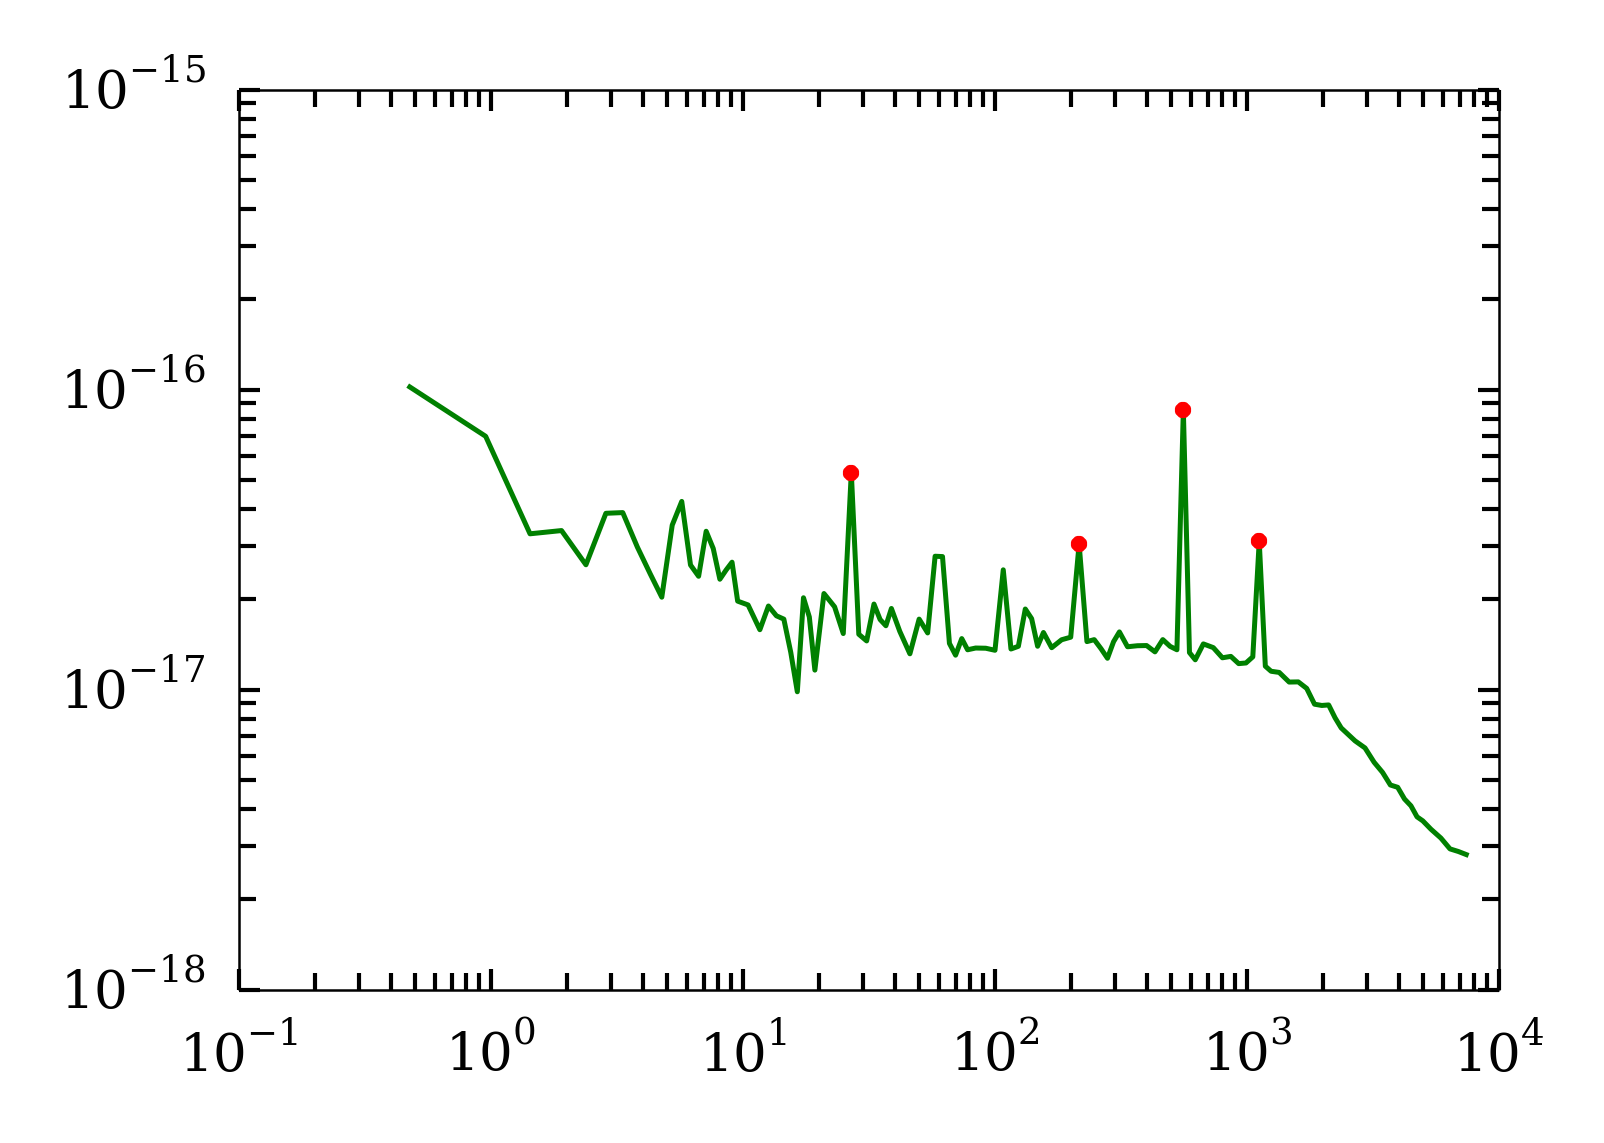

In [15]:
fig, ax = plt.subplots()

ax.loglog(bb06.pca_freq, bb06.pca_eigvals[1], '-g')
ax.loglog(bb06.epca_freq[bb_highest],
          bb06.epca_evals[1][bb_highest], '.r')

In [16]:
bb06.epca_freq[sorted(bb_highest)]

array([   26.94129944,   216.00723267,   559.80682373,  1119.85206604])

In [17]:
bb06._close_files()
del(bb06)

# Despike continuous-wave data

This is the highest optical power data that passes cuts:

In [38]:
cw07 = load_snm('cw', 7)

In [46]:
n_masked = 1
f_mask = 20
cw_highest = ((cw07.epca_freq <= f_mask).sum() +
               cw07.epca_evals[1][cw07.epca_freq > f_mask].argsort())[-n_masked:]

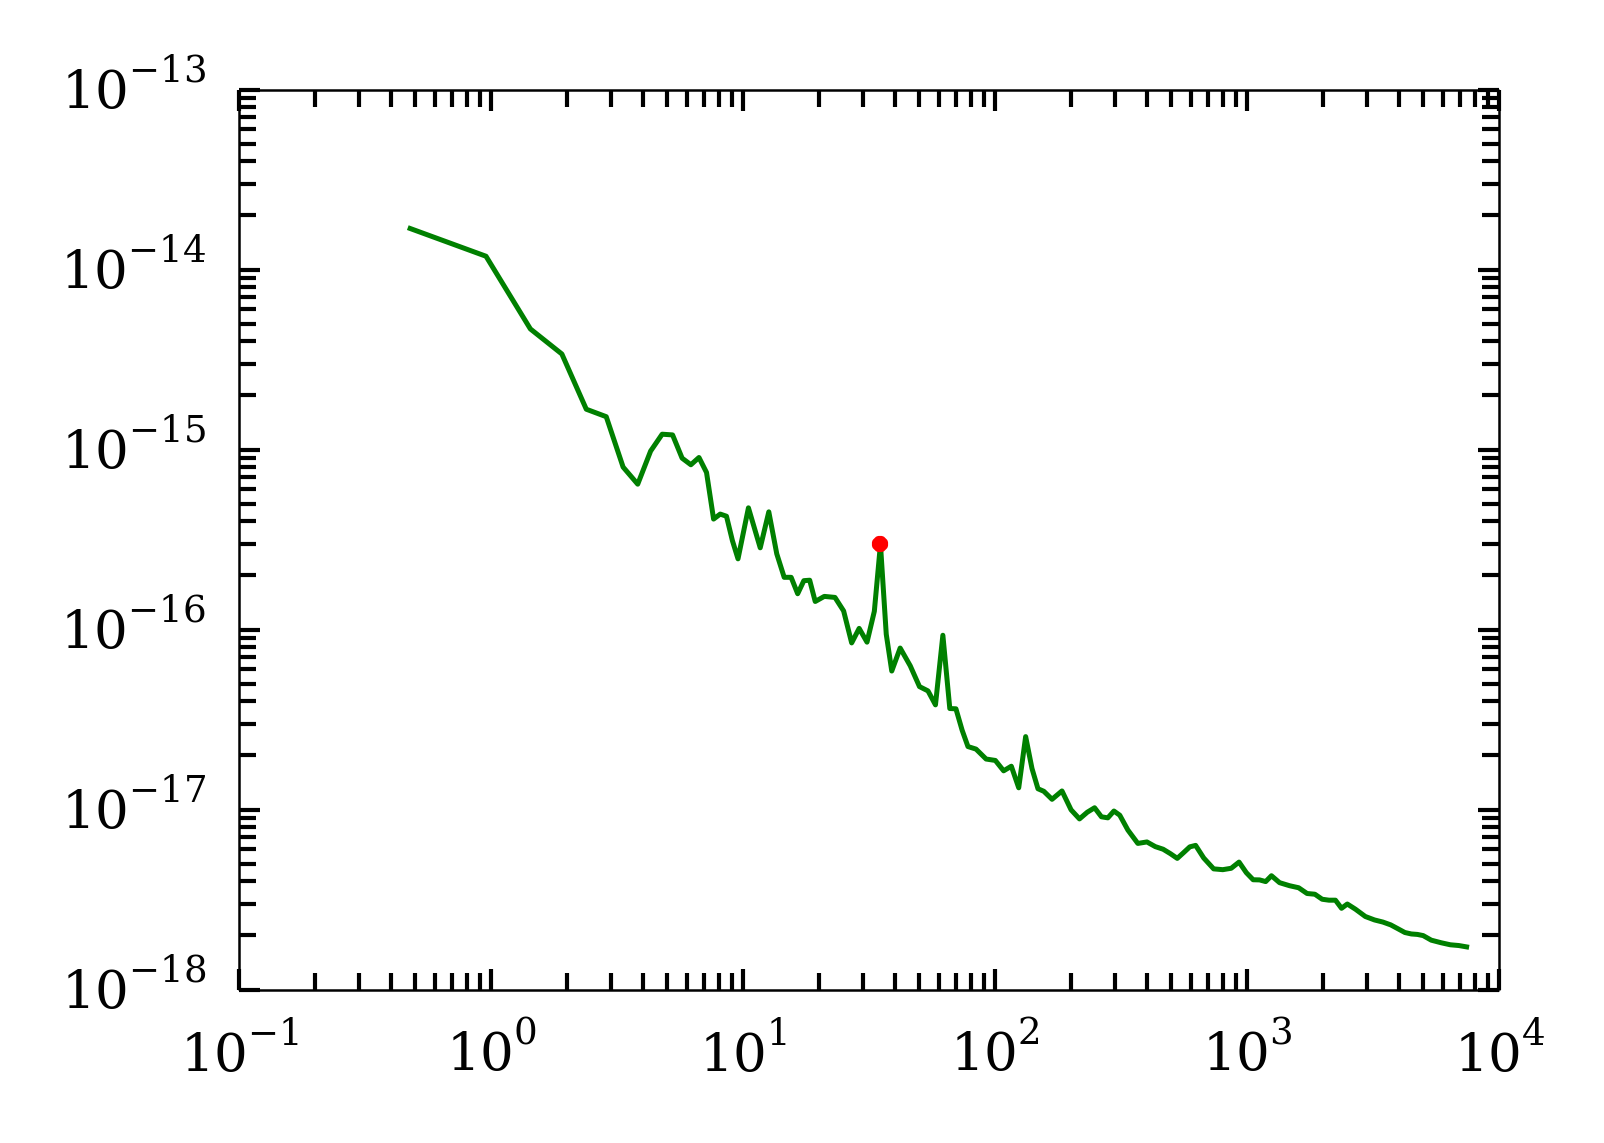

In [47]:
fig, ax = plt.subplots()

ax.loglog(cw07.pca_freq, cw07.pca_eigvals[1], '-g')
ax.loglog(cw07.epca_freq[cw_highest],
          cw07.epca_evals[1][cw_highest], '.r')

In [48]:
cw07._close_files()
del(cw07)

# Create all SNMs and save data

In [26]:
bb_data = {}

# Exclude 2 * 9 turns and 2 * 8.5 turns
for total_turns in range(6, 17):
    snm = load_snm('bb', total_turns)
    print("Turns: {} Atten: {}".format(sum(snm.mmw_atten_turns), snm.atten))
    bb_data['{:02.0f}_dev'.format(total_turns)] = snm.epca_evals[1]
    bb_data['{:02.0f}_sigma'.format(total_turns)] = snm.epca_variance[1]**(1/2)
    bb_data['{:02.0f}_amp'.format(total_turns)] = snm.epca_evals[0]

# Take the identical data from the last SNM:
bb_data['f'] = snm.epca_freq
bb_data['counts'] = snm.epca_counts
bb_data['highest'] = bb_highest

with open(os.path.join(save_directory, 'bb_log-binned_2015-12-21.npz'), 'w') as f:
    np.savez(f, **bb_data)

Turns: 6.0 Atten: 23.0
Turns: 7.0 Atten: 23.0
Turns: 8.0 Atten: 23.0
Turns: 9.0 Atten: 23.0
Turns: 10.0 Atten: 26.0
Turns: 11.0 Atten: 26.0
Turns: 12.0 Atten: 26.0
Turns: 13.0 Atten: 29.0
Turns: 14.0 Atten: 29.0
Turns: 15.0 Atten: 29.0
Turns: 16.0 Atten: 29.0


In [49]:
cw_data = {}

# Exclude 2 * 9 turns and 2 * 3 turns
for total_turns in range(7, 18):
    snm = load_snm('cw', total_turns)
    print("Turns: {} Atten: {}".format(sum(snm.mmw_atten_turns), snm.atten))
    cw_data['{:02.0f}_dev'.format(total_turns)] = snm.epca_evals[1]
    cw_data['{:02.0f}_sigma'.format(total_turns)] = snm.epca_variance[1]**(1/2)
    cw_data['{:02.0f}_amp'.format(total_turns)] = snm.epca_evals[0]

# Take the identical data from the last SNM:
cw_data['f'] = snm.epca_freq
cw_data['counts'] = snm.epca_counts
cw_data['highest'] = cw_highest

with open(os.path.join(save_directory, 'cw_log-binned_2015-12-21.npz'), 'w') as f:
    np.savez(f, **cw_data)

Turns: 7.0 Atten: 23.0
Turns: 8.0 Atten: 23.0
Turns: 9.0 Atten: 23.0
Turns: 10.0 Atten: 23.0
Turns: 11.0 Atten: 23.0
Turns: 12.0 Atten: 26.0
Turns: 13.0 Atten: 29.0
Turns: 14.0 Atten: 29.0
Turns: 15.0 Atten: 29.0
Turns: 16.0 Atten: 29.0
Turns: 17.0 Atten: 29.0


In [28]:
bbz = np.load(os.path.join(save_directory, 'bb_log-binned_2015-12-21.npz'))

In [29]:
cwz = np.load(os.path.join(save_directory, 'cw_log-binned_2015-12-21.npz'))

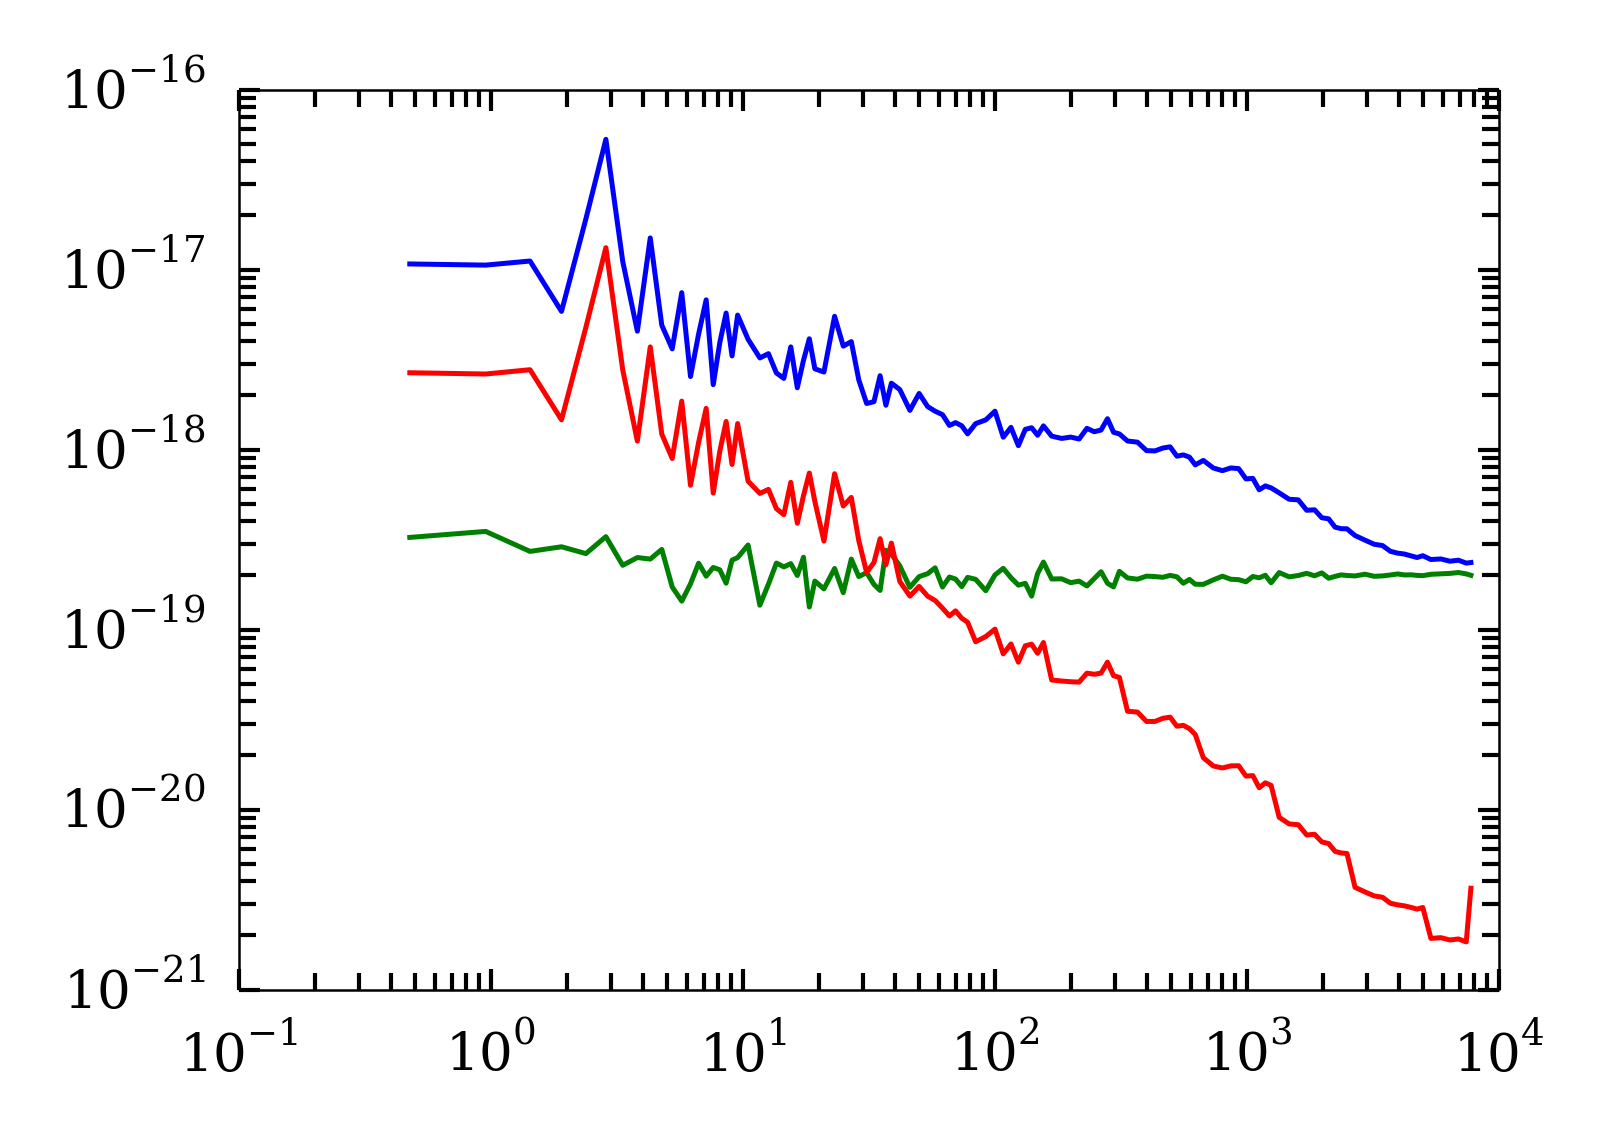

In [30]:
plt.loglog(bbz['f'], bbz['16_dev'])
plt.loglog(bbz['f'], bbz['16_amp'])
plt.loglog(bbz['f'], bbz['16_sigma'])

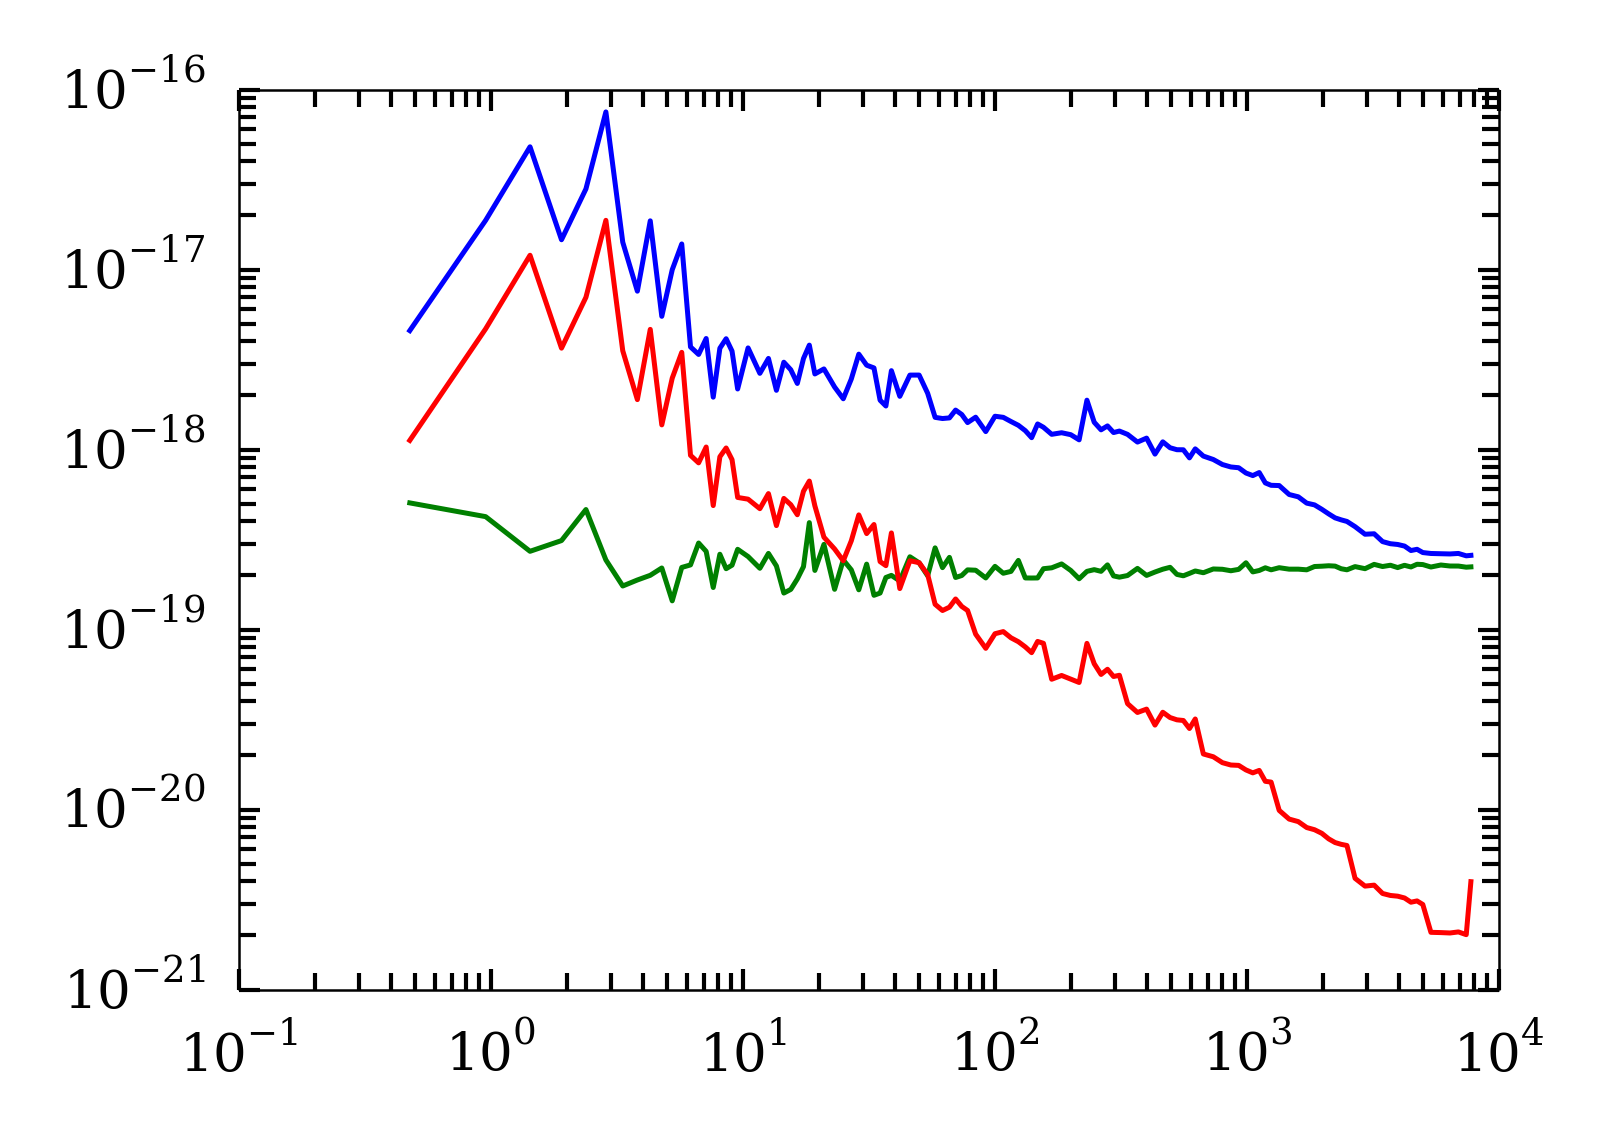

In [31]:
plt.loglog(cwz['f'], cwz['17_dev'])
plt.loglog(cwz['f'], cwz['17_amp'])
plt.loglog(cwz['f'], cwz['17_sigma'])

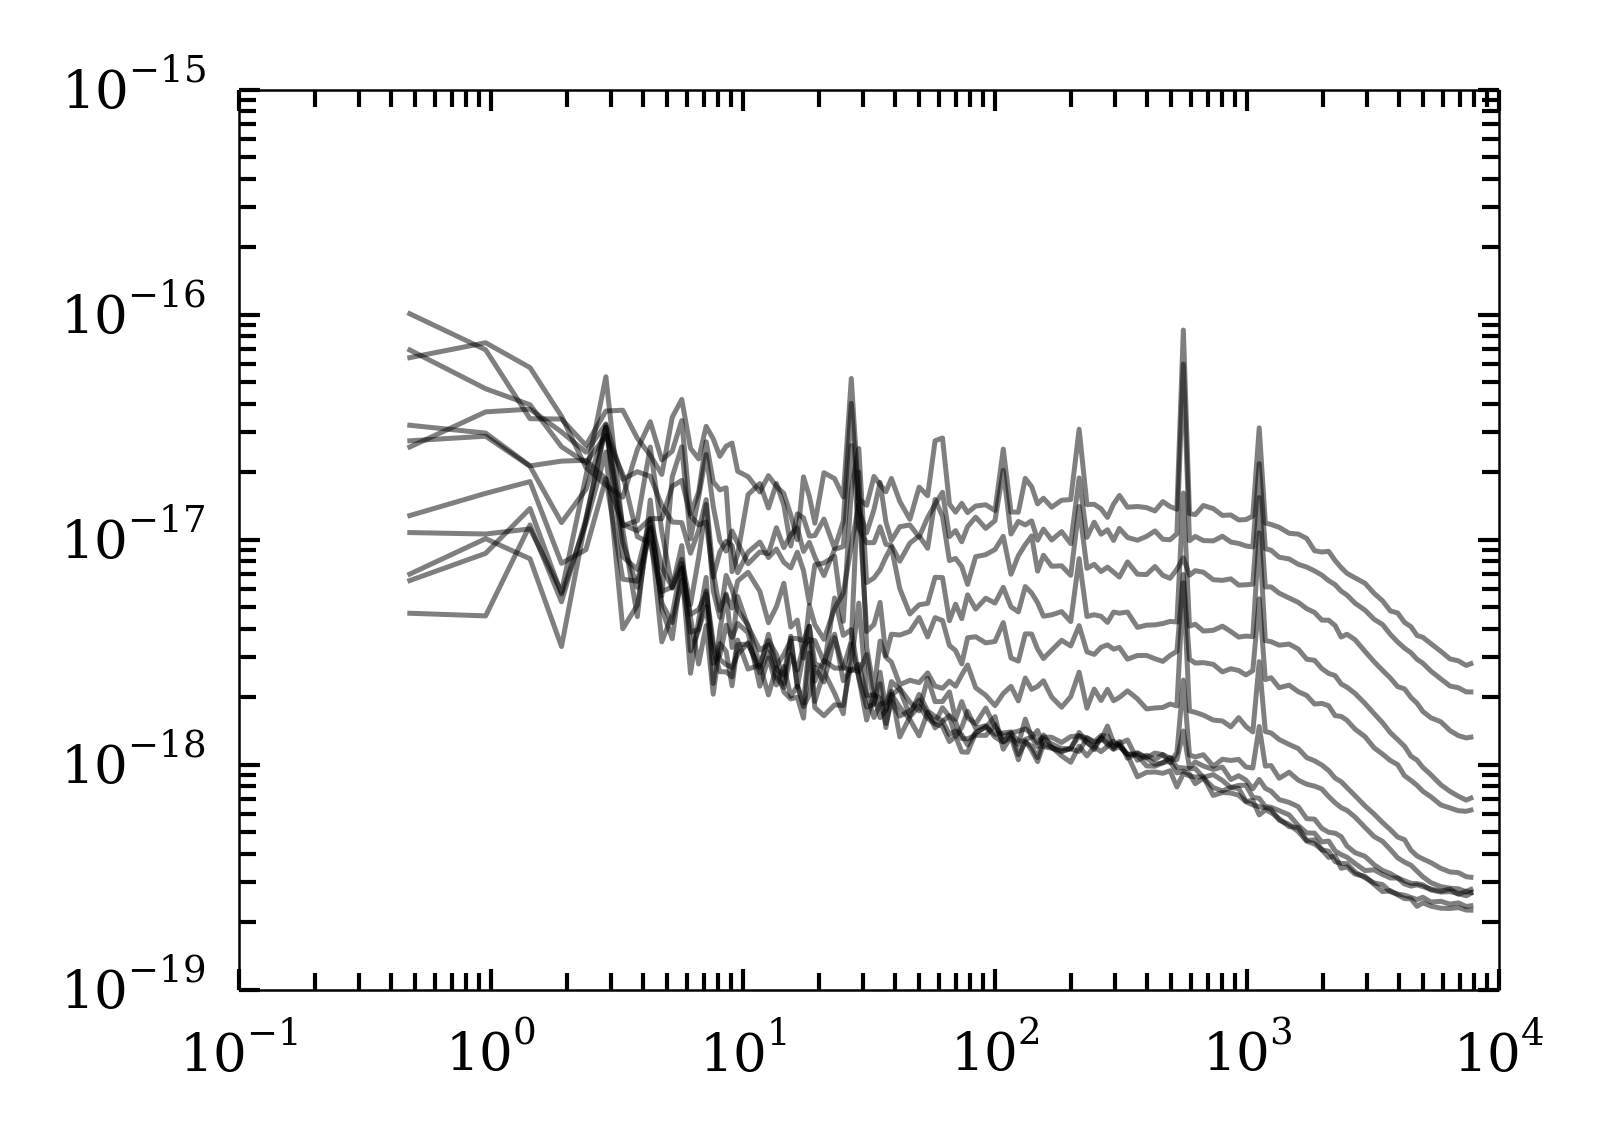

In [35]:
for bb_turns in range(6, 17):
    plt.loglog(bbz['f'], bbz['{:02.0f}_dev'.format(bb_turns)], '-k', alpha=0.5)

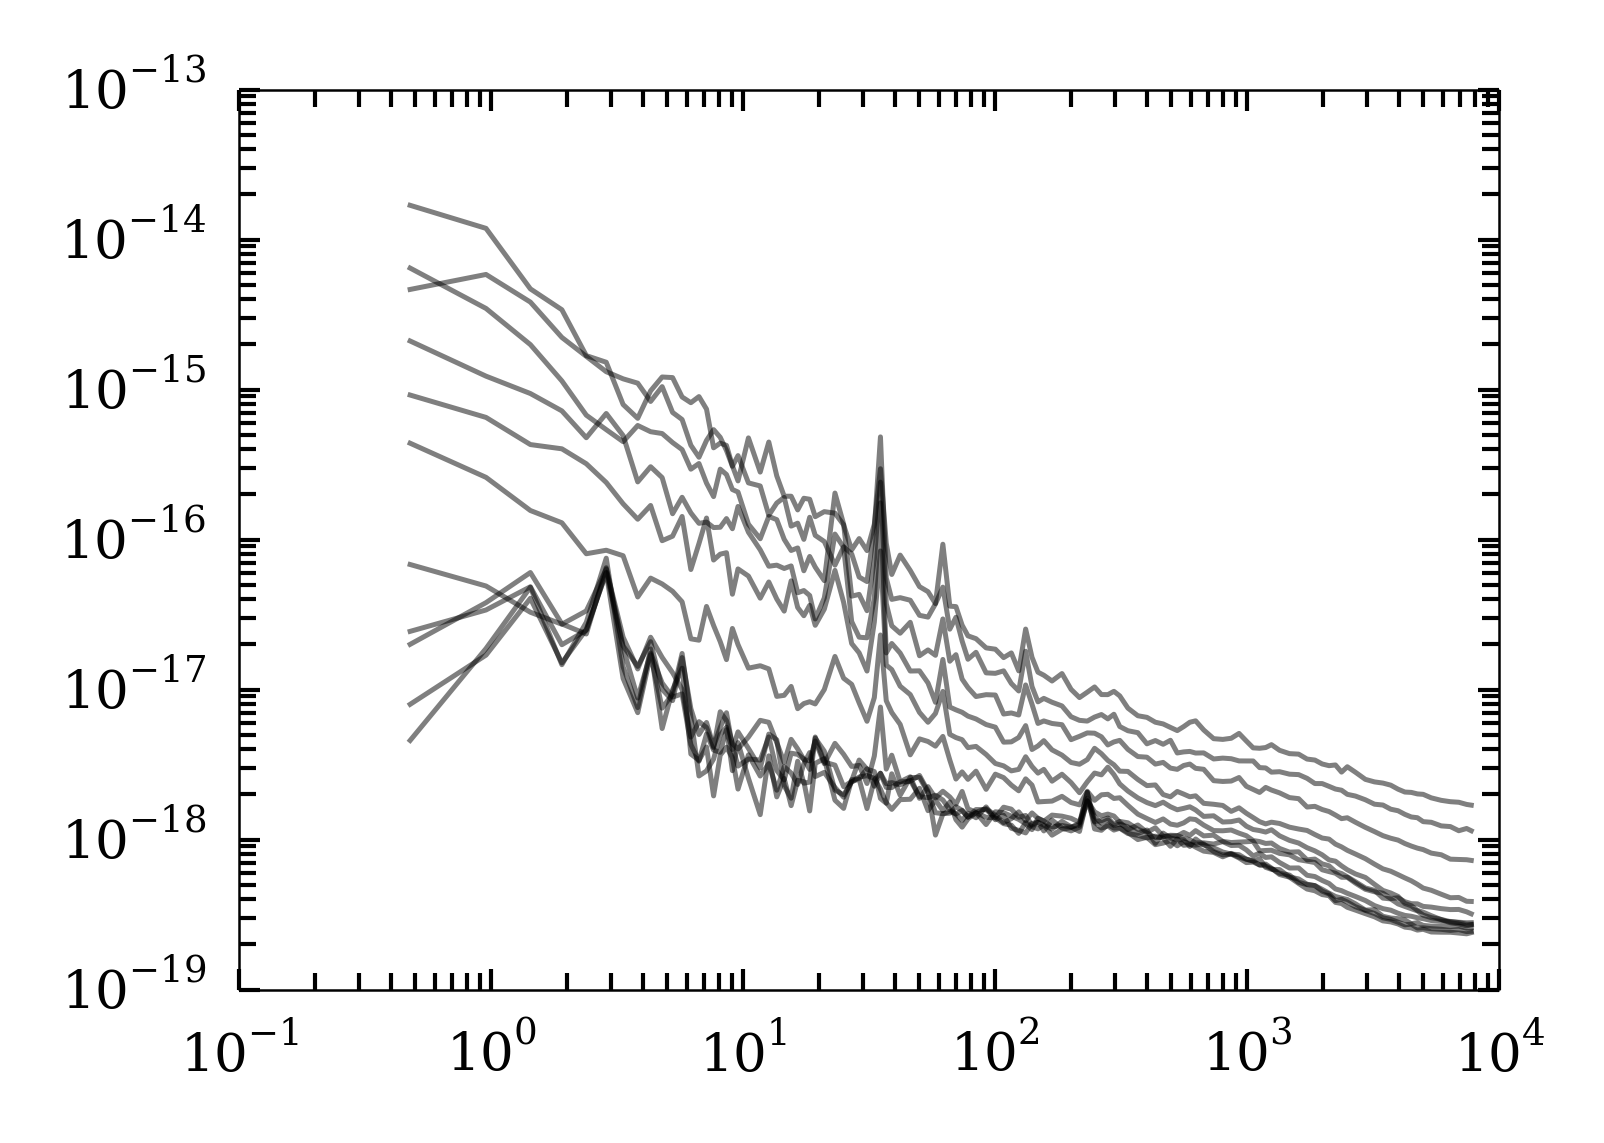

In [36]:
for cw_turns in range(7, 18):
    plt.loglog(cwz['f'], cwz['{:02.0f}_dev'.format(cw_turns)], '-k', alpha=0.5)